In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder 
from catboost import CatBoostRegressor
%matplotlib inline
import matplotlib.pyplot as plt

### Загрузка

In [2]:
produv_train = pd.read_csv('produv_train.csv', parse_dates=['SEC'])
lom_train = pd.read_csv('lom_train.csv')
plavki_train = pd.read_csv('plavki_train.csv', parse_dates=['plavka_VR_NACH', 'plavka_VR_KON'])
sip_train = pd.read_csv('sip_train.csv', parse_dates=['DAT_OTD'])
chronom_train = pd.read_csv('chronom_train.csv', parse_dates=['VR_NACH','VR_KON'], usecols=[1, 2, 3, 4, 5, 6])
chugun_train = pd.read_csv('chugun_train.csv', parse_dates=['DATA_ZAMERA'])
gas_train = pd.read_csv('gas_train.csv', parse_dates=['Time'])
target_train = pd.read_csv('target_train.csv')

In [3]:
produv_test = pd.read_csv('produv_test.csv', parse_dates=['SEC'])
lom_test = pd.read_csv('lom_test.csv')
plavki_test = pd.read_csv('plavki_test.csv', parse_dates=['plavka_VR_NACH', 'plavka_VR_KON'])
sip_test = pd.read_csv('sip_test.csv', parse_dates=['DAT_OTD'])
chronom_test = pd.read_csv('chronom_test.csv', parse_dates=['VR_NACH','VR_KON'], usecols=[1, 2, 3, 4, 5, 6])
chugun_test = pd.read_csv('chugun_test.csv', parse_dates=['DATA_ZAMERA'])
gas_test = pd.read_csv('gas_test.csv', parse_dates=['Time'])

### Смотрим обучающие данные

In [4]:
produv_train.head(5)

,NPLV,SEC,RAS,POL
0,510008,2021-01-01 03:18:26,382.0,3.92
1,510008,2021-01-01 03:18:28,382.0,3.92
2,510008,2021-01-01 03:18:30,553.0,3.92
3,510008,2021-01-01 03:18:32,701.0,3.92
4,510008,2021-01-01 03:18:34,813.0,3.92


In [5]:
produv_train.shape

(4729802, 4)

In [6]:
produv_train.describe()

,NPLV,RAS,POL
count,4.729802e+06,4.729802e+06,4.729802e+06
mean,5.112559e+05,3.816291e+02,4.645886e+00
std,7.064421e+02,2.887899e+02,2.326494e+00
min,5.100080e+05,0.000000e+00,0.000000e+00
25%,5.106550e+05,1.674842e+02,3.212459e+00
50%,5.112470e+05,2.776382e+02,4.709795e+00
75%,5.118900e+05,4.600000e+02,6.267165e+00
max,5.123220e+05,1.130000e+03,1.701000e+01


In [7]:
produv_train[produv_train.NPLV == 510008].count(), produv_train[produv_train.NPLV == 510008]['SEC'].max()-produv_train[produv_train.NPLV == 510008]['SEC'].min()

(NPLV    2055
 SEC     2055
 RAS     2055
 POL     2055
 dtype: int64,
 Timedelta('0 days 01:08:28'))

In [8]:
produv_train.groupby('NPLV')['NPLV'].count().sort_values()

NPLV
510189       912
512227      1058
512229      1109
512060      1155
512063      1165
           ...  
510294     18065
511929     18236
510167     19369
510437     20825
512322    385864
Name: NPLV, Length: 2063, dtype: int64

Уникальная плавка с продувкой более 385 тысяч раз.

In [9]:
produv_train[produv_train.NPLV == 512322]['SEC'].max()-produv_train[produv_train.NPLV == 512322]['SEC'].min()

Timedelta('8 days 22:22:06')

In [10]:
produv_train[produv_train.NPLV == 512322]

,NPLV,SEC,RAS,POL
4343938,512322,2021-04-26 18:08:48,383.000000,3.570000
4343939,512322,2021-04-26 18:08:50,569.000000,3.490000
4343940,512322,2021-04-26 18:08:52,745.000000,3.490000
4343941,512322,2021-04-26 18:08:54,870.000000,3.490000
4343942,512322,2021-04-26 18:08:56,954.000000,3.340000
...,...,...,...,...
4729797,512322,2021-05-05 16:30:46,363.996249,4.850045
4729798,512322,2021-05-05 16:30:48,363.996999,4.850036
4729799,512322,2021-05-05 16:30:50,363.997749,4.850027
4729800,512322,2021-05-05 16:30:52,363.998499,4.850018


In [11]:
produv_train.isna().sum()

NPLV    0
SEC     0
RAS     0
POL     0
dtype: int64

<AxesSubplot:>

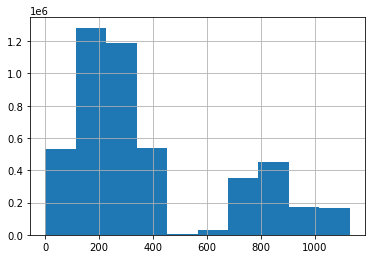

In [12]:
produv_train.RAS.hist()

<AxesSubplot:>

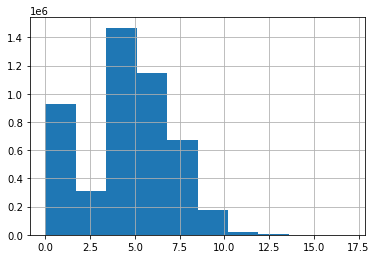

In [13]:
produv_train.POL.hist()

In [14]:
t = produv_train.groupby('NPLV')['SEC'].agg(['min', 'max'])
(t['max']-t['min']).median()

Timedelta('0 days 01:02:16')

In [15]:
lom_train.head()

,NPLV,VDL,NML,VES
0,510008,4,К,56500
1,510008,8,О,16700
2,510008,13,КП,3000
3,510009,4,К,49800
4,510009,8,О,22800


<AxesSubplot:>

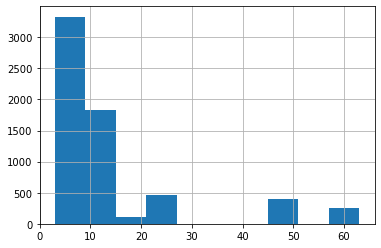

In [16]:
lom_train.VDL.hist()

<AxesSubplot:>

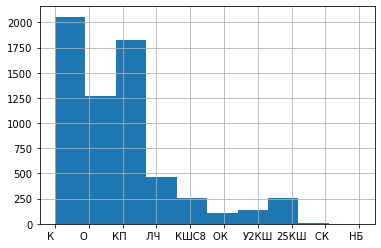

In [17]:
lom_train.NML.hist()

<AxesSubplot:>

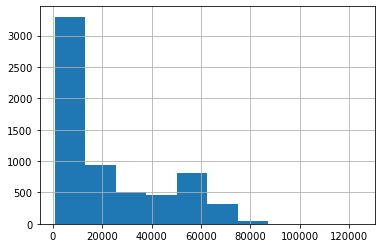

In [18]:
lom_train.VES.hist()

In [19]:
lom_train.isna().sum()

NPLV    0
VDL     0
NML     0
VES     0
dtype: int64

In [20]:
plavki_train.head()

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15


In [21]:
plavki_train.shape

(2137, 10)

In [22]:
plavki_train.NPLV.value_counts()

511135    75
511988     1
511207     1
511209     1
511211     1
          ..
510466     1
510468     1
510470     1
510472     1
512004     1
Name: NPLV, Length: 2063, dtype: int64

In [23]:
plavki_train[plavki_train.NPLV==511135].head()

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
1007,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,63,5 сопловая,161
1008,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,64,5 сопловая,162
1009,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,65,5 сопловая,163
1010,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,66,5 сопловая,164
1011,511135,2021-02-27 20:27:36,2021-02-27 21:28:44,С255,МНЛЗ,2098,цилиндрическая,67,5 сопловая,165


In [24]:
plavki_train[plavki_train.NPLV==511135]['plavka_ST_FURM'].value_counts()

92    1
20    1
22    1
23    1
24    1
     ..
68    1
69    1
70    1
71    1
2     1
Name: plavka_ST_FURM, Length: 75, dtype: int64

Один номер плавки встречается 75 раз с разным положением и номером фурм. Выкинем это.

In [25]:
plavki_train = plavki_train[plavki_train.NPLV!=511135]

In [26]:
plavki_train = plavki_train.reset_index(drop=True)
plavki_train

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,510008,2021-01-01 03:08:11,2021-01-01 03:51:10,С255,МНЛЗ,971,цилиндрическая,11,5 сопловая,11
1,510009,2021-01-01 04:00:44,2021-01-01 05:07:28,С255,МНЛЗ,972,цилиндрическая,12,5 сопловая,12
2,510010,2021-01-01 05:12:29,2021-01-01 06:00:53,Ст3пс/Э,Изл,973,цилиндрическая,13,5 сопловая,13
3,510011,2021-01-01 06:13:48,2021-01-01 07:08:39,Св-08А.z02,Изл,974,цилиндрическая,14,5 сопловая,14
4,510012,2021-01-01 07:13:44,2021-01-01 08:01:59,SC2M/ЭТ,МНЛС,975,цилиндрическая,15,5 сопловая,15
...,...,...,...,...,...,...,...,...,...,...
2057,512318,2021-04-26 13:04:26,2021-04-26 13:55:50,C071TM.z01/ЭТ,МНЛС,3281,коническая,22,5 сопловая,56
2058,512319,2021-04-26 14:10:20,2021-04-26 15:14:23,C071TM.z01/ЭТ,МНЛС,3282,коническая,23,5 сопловая,57
2059,512320,2021-04-26 15:21:37,2021-04-26 16:16:42,40Х.1,МНЛЗ,3283,коническая,24,5 сопловая,58
2060,512321,2021-04-26 16:22:37,2021-04-26 17:23:37,40Х.1,МНЛЗ,3284,коническая,25,5 сопловая,59


In [27]:
sip_train.head()

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20


In [28]:
sip_train[sip_train['NPLV']==510008]

,NPLV,VDSYP,NMSYP,VSSYP,DAT_OTD
0,510008,346,Уголь ТО,570,2021-01-01 03:03:53
1,510008,346,Уголь ТО,220,2021-01-01 03:04:10
2,510008,408,изв_ЦОИ,7300,2021-01-01 03:08:17
3,510008,346,Уголь ТО,270,2021-01-01 03:09:03
4,510008,346,Уголь ТО,430,2021-01-01 03:09:20
5,510008,346,Уголь ТО,1460,2021-01-01 03:10:22
6,510008,408,изв_ЦОИ,810,2021-01-01 03:11:39
7,510008,171,Флюс ФОМИ,980,2021-01-01 03:11:39
8,510008,442,ФЛЮМАГ,2960,2021-01-01 03:14:36
9,510008,408,изв_ЦОИ,2010,2021-01-01 03:27:26


In [29]:
sip_train.groupby('NPLV')['NPLV'].count().sort_values()

NPLV
512129     3
512212     3
511965     3
512223     3
512051     3
          ..
511862    32
510200    34
510032    34
511232    39
511827    43
Name: NPLV, Length: 2063, dtype: int64

<AxesSubplot:>

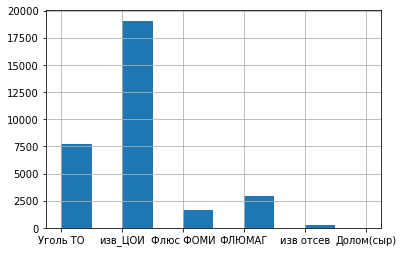

In [30]:
sip_train.NMSYP.hist()

<AxesSubplot:>

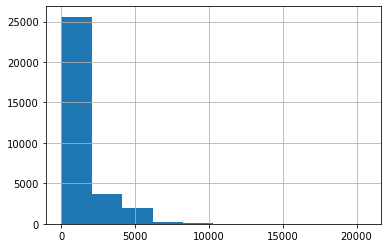

In [31]:
sip_train.VSSYP.hist()

In [32]:
chronom_train.head()

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
1,510008,межпл.прост.,межпл. простой,2021-01-01 03:01:07,2021-01-01 03:08:11,NaN
2,510008,межпл.прост.,Осмотр конвертера,2021-01-01 03:01:19,2021-01-01 03:03:43,NaN
3,510008,межпл.прост.,Наведение гарнисажа,2021-01-01 03:03:43,2021-01-01 03:05:23,NaN
4,510008,межпл.прост.,Слив шлака,2021-01-01 03:05:23,2021-01-01 03:06:09,NaN


In [33]:
chronom_train.shape

(34406, 6)

<AxesSubplot:>

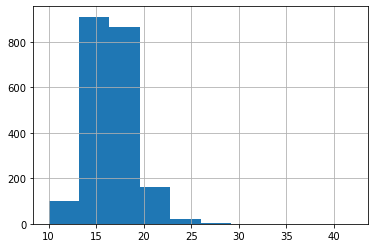

In [34]:
chronom_train.groupby('NPLV')['NPLV'].count().hist()

In [35]:
chronom_train[chronom_train.VR_NACH < '2021-01-01']

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,510008,межпл.прост.,межпл. простой,2011-01-01 10:28:13,2011-01-01 10:32:15,NaN
16,510009,межпл.прост.,межпл. простой,2011-01-01 11:27:20,2011-01-01 11:31:51,NaN
34,510010,межпл.прост.,межпл. простой,2011-01-01 12:28:03,2011-01-01 12:33:16,NaN
48,510011,межпл.прост.,межпл. простой,2011-01-01 13:17:52,2011-01-01 13:28:18,NaN
63,510012,межпл.прост.,межпл. простой,2011-01-01 14:31:03,2011-01-01 14:41:27,NaN
...,...,...,...,...,...,...
34341,512319,межпл.прост.,межпл. простой,2011-05-07 16:16:44,2011-05-07 16:27:44,NaN
34342,512319,вн.пл.прост.,Отсутствие чугуна,2011-05-07 16:36:12,2011-05-07 16:48:18,NaN
34359,512320,межпл.прост.,межпл. простой,2011-05-07 17:29:53,2011-05-07 17:37:24,NaN
34374,512321,межпл.прост.,межпл. простой,2011-05-07 18:20:06,2011-05-07 18:29:19,NaN


In [36]:
chronom_train['TYPE_OPER'].value_counts()

опер            21442
межпл.прост.    11420
вн.пл.прост.     1544
Name: TYPE_OPER, dtype: int64

In [37]:
chronom_train['NOP'].value_counts()

Слив шлака              4264
межпл. простой          4125
Нагрев лома             3664
Повалка                 3356
Выпуск металла          2065
Заливка чугуна          2063
Завалка лома            2063
Продувка                2063
Наведение гарнисажа     2027
Прерыв. выпуска         2015
Осмотр конвертера       1853
Отсечка шлака            860
Отсутствие чугуна        630
Додувка на t             557
Додувка на C             531
Обрыв горловины          434
Наложение продувки       327
Вхождение в гр.МНЛЗ      322
Полусухое торкрет.       182
Отсутствие O2            155
Неиспр. электр. обор     149
Охл. азотом              143
Подварка  футеровки      141
Ожидание стальковша       79
Замер положения фурм      72
Неиспр. механ. обор.      64
Отсутствие мет.шихты      49
Замена фурмы              36
ППР                       34
Ожидание шл.чаш           30
Отсут. своб.разл.пл.      23
Ремонт летки              13
Неиспр. энерг. обор       11
Неиспр. АСУ и КИПиА        5
Скач. шлака   

In [38]:
chronom_train[chronom_train['O2']>0]['NOP'].value_counts()

Нагрев лома     1798
Додувка на t     549
Додувка на C     524
Name: NOP, dtype: int64

In [39]:
chronom_train['O2'].value_counts()

0.0       45
1.0       38
1819.0    10
1895.0     8
1512.0     8
          ..
1537.0     1
2064.0     1
1551.0     1
2597.0     1
2560.0     1
Name: O2, Length: 1547, dtype: int64

In [40]:
chugun_train.head()

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,510008,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,0.01,0.03,0.103,0.084,2021-01-01 03:15:03
1,510009,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,0.01,0.03,0.084,0.096,2021-01-01 04:23:48
2,510010,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,0.01,0.03,0.115,0.110,2021-01-01 05:21:40
3,510011,264000.0,1401.0,0.48,0.27,0.018,0.091,0.03,0.01,0.02,0.112,0.110,2021-01-01 06:20:57
4,510012,263300.0,1422.0,0.47,0.23,0.018,0.096,0.02,0.01,0.03,0.083,0.070,2021-01-01 07:23:02


In [41]:
chugun_train.shape

(2063, 13)

<AxesSubplot:>

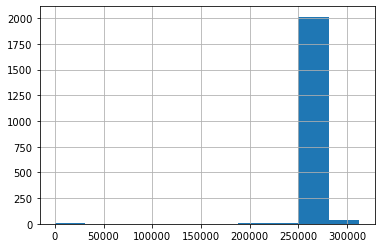

In [42]:
chugun_train['VES'].hist()

<AxesSubplot:>

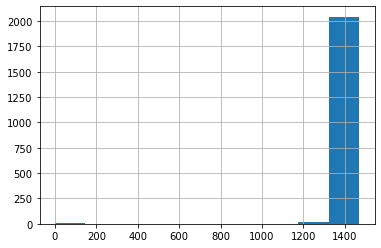

In [43]:
chugun_train['T'].hist()

In [44]:
gas_train.head()

,NPLV,Time,V,T,O2,N2,H2,CO2,CO,AR,T фурмы 1,T фурмы 2,O2_pressure
0,510008,2021-01-01 03:08:11.437,218263.343750,262.847229,18.722993,80.132247,0.087755,0.163878,0.009229,0.893243,0.0,0.0,13.085938
1,510008,2021-01-01 03:08:12.437,218263.343750,262.847229,18.732721,80.138406,0.087959,0.148980,0.008390,0.892948,0.0,0.0,13.085938
2,510008,2021-01-01 03:08:13.437,218369.359375,262.152771,18.742449,80.144565,0.088163,0.134082,0.007551,0.892653,0.0,0.0,13.085938
3,510008,2021-01-01 03:08:14.437,218475.359375,261.805573,18.752177,80.150724,0.088367,0.119184,0.006712,0.892358,0.0,0.0,13.093172
4,510008,2021-01-01 03:08:15.437,218369.359375,260.763885,18.761905,80.156883,0.088571,0.104286,0.005873,0.892063,0.0,0.0,13.093172


In [45]:
gas_train.shape

(6468018, 13)

In [46]:
gas_train.groupby('NPLV')['NPLV'].count().sort_values()

NPLV
510829    1847
511928    1988
512158    2039
512073    2051
512149    2064
          ... 
511938    7177
512065    7198
511953    7259
512112    7597
510949    8164
Name: NPLV, Length: 2063, dtype: int64

In [47]:
target_train.head()

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120


In [48]:
target_train.isna().sum()

NPLV    0
TST     0
C       2
dtype: int64

In [49]:
na = target_train[target_train['C'].isna()]['NPLV']
na

1024    511156
2041    512299
Name: NPLV, dtype: int64

Две плавки в таргете не имеют меток, тоже избавимся от них в трейне.

In [50]:
target_train = target_train[target_train['NPLV']!=511135]

In [51]:
target_train = target_train.dropna().reset_index(drop=True)

In [52]:
target_train

,NPLV,TST,C
0,510008,1690,0.060
1,510009,1683,0.097
2,510010,1662,0.091
3,510011,1609,0.410
4,510012,1682,0.120
...,...,...,...
2055,512318,1626,0.145
2056,512319,1643,0.087
2057,512320,1615,0.141
2058,512321,1654,0.270


In [53]:
plavki_train = plavki_train[(plavki_train['NPLV']!=511156)&(plavki_train['NPLV']!=512299)]

### Смотрим тестовые данные

In [54]:
produv_test.head()

,NPLV,SEC,RAS,POL
0,512324,2021-05-05 17:43:18,181.0,4.2
1,512324,2021-05-05 17:43:20,215.0,4.2
2,512324,2021-05-05 17:43:22,243.0,4.2
3,512324,2021-05-05 17:43:24,265.0,4.2
4,512324,2021-05-05 17:43:26,273.0,4.2


In [55]:
t1 = produv_test.groupby('NPLV')['SEC'].agg(['min', 'max'])
(t1['max']-t1['min']).sort_values()

NPLV
513374   0 days 00:29:48
512533   0 days 00:35:34
512951   0 days 00:36:52
512554   0 days 00:37:24
513085   0 days 00:37:44
               ...      
512990   0 days 09:12:08
512434   0 days 09:36:26
512762   0 days 09:38:54
513241   0 days 10:31:46
512614   0 days 11:08:08
Length: 780, dtype: timedelta64[ns]

In [56]:
plavki_test.head()

,NPLV,plavka_VR_NACH,plavka_VR_KON,plavka_NMZ,plavka_NAPR_ZAD,plavka_STFUT,plavka_TIPE_FUR,plavka_ST_FURM,plavka_TIPE_GOL,plavka_ST_GOL
0,512324,2021-05-05 17:41:21,2021-05-05 18:46:07,Ст3пс/Э,Изл,2,цилиндрическая,2,4-сопл х54,2
1,512327,2021-05-05 21:07:01,2021-05-05 22:02:26,C121TM/ЭТ,МНЛС,5,цилиндрическая,5,4-сопл х54,5
2,512328,2021-05-05 22:03:12,2021-05-05 23:39:32,Ст3пс/Э,Изл,6,цилиндрическая,6,4-сопл х54,6
3,512331,2021-05-06 02:21:46,2021-05-06 03:49:18,25Г2С,Изл,9,цилиндрическая,9,4-сопл х54,9
4,512333,2021-05-06 05:22:03,2021-05-06 06:25:51,C091TM.z01/ЭТ,МНЛС,11,цилиндрическая,11,4-сопл х54,11


In [57]:
chronom_test.head()

,NPLV,TYPE_OPER,NOP,VR_NACH,VR_KON,O2
0,512324,межпл.прост.,межпл. простой,2011-05-07 21:28:59,2011-05-07 21:33:38,NaN
1,512324,межпл.прост.,межпл. простой,2021-05-05 17:35:55,2021-05-05 17:41:21,NaN
2,512324,межпл.прост.,Осмотр конвертера,2021-05-05 17:36:07,2021-05-05 17:39:07,NaN
3,512324,межпл.прост.,Слив шлака,2021-05-05 17:39:07,2021-05-05 17:41:20,NaN
4,512324,опер,Завалка лома,2021-05-05 17:41:21,2021-05-05 17:43:16,NaN


In [58]:
chugun_test.head()

,NPLV,VES,T,SI,MN,S,P,CR,NI,CU,V,TI,DATA_ZAMERA
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,0.048,0.030,2021-05-05 17:22:54
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,0.050,0.024,2021-05-05 20:00:30
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-05 22:29:21
3,512331,266700.0,1383.0,0.54,0.39,0.028,0.115,0.02,0.01,0.03,0.059,0.042,2021-05-06 01:58:11
4,512333,267400.0,1387.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,0.000,0.000,2021-05-06 05:27:08


### Конкатенация

In [59]:
plav_ = pd.concat([plavki_train, plavki_test]).reset_index(drop=True)

chugun_ = pd.concat([chugun_train, chugun_test]).reset_index(drop=True)

lom_ = pd.concat([lom_train, lom_test]).reset_index(drop=True)

sip_ = pd.concat([sip_train, sip_test]).reset_index(drop=True)

gas_ = pd.concat([gas_train, gas_test]).reset_index(drop=True)

produv_ = pd.concat([produv_train, produv_test]).reset_index(drop=True)

chronom_ = pd.concat([chronom_train, chronom_test]).reset_index(drop=True)

### Обработка

In [60]:
encoder = OrdinalEncoder()

Подготовим признаки для объединения в один датафрейм

In [61]:
def plavki(x):
    t1 = x.drop(['plavka_STFUT', 'plavka_ST_FURM', 'plavka_ST_GOL'], axis=1)
    t1['plavka_timedelta'] = (t1['plavka_VR_KON']-t1['plavka_VR_NACH'])/np.timedelta64(1,'s')
    t1['plavka_NMZ'] = t1['plavka_NMZ'].str.replace(' ', '')
    t1['plavka_TIPE_GOL'] = t1['plavka_TIPE_GOL'].str.replace(' ', '')
    t2 = pd.DataFrame(encoder.fit_transform(t1.select_dtypes(include=['object'])), columns=t1.select_dtypes(include=['object']).columns)
    t1 = t1.drop(['plavka_VR_NACH','plavka_VR_KON', 'plavka_NMZ','plavka_NAPR_ZAD','plavka_TIPE_FUR', 'plavka_TIPE_GOL'], axis=1).join(t2)
    return t1

In [62]:
def chugun(x):
    t1 = x.drop('DATA_ZAMERA', axis=1)
    return t1

In [63]:
def lom(x):
    t1 = x.pivot(index='NPLV', columns='NML', values='VES').fillna(0)
    return t1

In [64]:
def sip(x):
    t1 = x.pivot_table(index='NPLV', columns='NMSYP', values='VSSYP', aggfunc='sum').fillna(0)
    t1['долом_сыр']=t1['долом_сыр']+t1['Долом(сыр)']
    t1['изв_отсев']=t1['изв_отсев']+t1['изв отсев']
    t1 = t1.drop(['Долом(сыр)', 'изв отсев'], axis=1)
    t2 = x.groupby(['NPLV'])['DAT_OTD'].agg(['min', 'max'])
    t2['sip_seconds'] = (t2['max']-t2['min'])/np.timedelta64(1,'s')
    pivot = t1.merge(t2, on='NPLV')
    pivot = pivot.drop(['min', 'max'], axis=1)
    pivot.columns = ['Уголь_ТО', 'ФЛЮМАГ', 'Флюс_ФОМИ', 'агл_офл_с', 'долом_сыр', 'изв_ЦОИ', 'изв_отсев', 'кокс_25_40', 'sip_seconds']
    return pivot

In [65]:
def gas(x):
    min_gas = x.groupby('NPLV')['Time'].min()
    max_gas = x.groupby('NPLV')['Time'].max()
    gas_start = x.query('Time in @min_gas')
    gas_end = x.query('Time in @max_gas')
    merged = gas_start.merge(gas_end, on='NPLV', suffixes=('_start', '_end'))
    merged = merged.drop(['Time_start', 'Time_end', 'T фурмы 1_end', 'T фурмы 2_end'], axis=1)
    return merged

In [66]:
def produv(x):
    t1 = x.groupby('NPLV').agg(['min', 'max', 'median', 'sum', 'count'])
    t1.columns = ['RAS_min', 'RAS_max', 'RAS_median', 'RAS_sum', 'RAS_count', 'POL_min', 'POL_max', 'POL_median', 'POL_sum', 'count']
    t2 = x.groupby('NPLV')['SEC'].agg(['min', 'max'])
    t2.columns = ['SEC_min', 'SEC_max']
    t2['SEC_delta'] = (t2['SEC_max']-t2['SEC_min'])/np.timedelta64(1,'s')
    t2 = t2.drop(['SEC_min', 'SEC_max'], axis=1)
    t1 = t1.drop(['RAS_count', 'POL_sum'], axis=1)
    merged = t1.merge(t2, on='NPLV')
    return merged

In [67]:
def chronom(x):
    t1 = x.pivot_table(index='NPLV', columns='NOP', values='O2', aggfunc='sum')
    t1 = t1[['Нагрев лома', 'Додувка на t', 'Додувка на C']].fillna(0)
    t1.columns = ['nagrev', 'doduvka_t', 'doduvka_c']
    return t1

Соберём все фичи

In [68]:
def features(plavki, chugun, lom, sip, gas, produv, chronom):
    feature = plavki.merge(chugun, on='NPLV')\
                             .merge(lom, on='NPLV')\
                             .merge(sip, on='NPLV')\
                             .merge(gas, on='NPLV')\
                             .merge(produv, on='NPLV')\
                             .merge(chronom, on='NPLV')
    features_train = feature.query('NPLV in @target_train.NPLV')
    features_test = feature.query('NPLV not in @target_train.NPLV').reset_index(drop=True)
    return features_train, features_test

In [69]:
plavki_all = plavki(plav_)
chugun_all = chugun(chugun_)
lom_all = lom(lom_)
sip_all = sip(sip_)
gas_all = gas(gas_)
produv_all = produv(produv_)
chronom_all = chronom(chronom_)

Выделим трейн и тест

In [70]:
features_train = features(plavki_all, chugun_all, lom_all, sip_all, gas_all, produv_all, chronom_all)[0]
features_test = features(plavki_all, chugun_all, lom_all, sip_all, gas_all, produv_all, chronom_all)[1]

Добавим признак мощности

In [71]:
features_train['power'] = features_train['VES']*100000/features_train['plavka_timedelta']
features_test['power'] = features_test['VES']*100000/features_test['plavka_timedelta']

In [72]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 69 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NPLV               780 non-null    int64  
 1   plavka_timedelta   780 non-null    float64
 2   plavka_NMZ         780 non-null    float64
 3   plavka_NAPR_ZAD    780 non-null    float64
 4   plavka_TIPE_FUR    780 non-null    float64
 5   plavka_TIPE_GOL    780 non-null    float64
 6   VES                780 non-null    float64
 7   T                  780 non-null    float64
 8   SI                 780 non-null    float64
 9   MN                 780 non-null    float64
 10  S                  780 non-null    float64
 11  P                  780 non-null    float64
 12  CR                 780 non-null    float64
 13  NI                 780 non-null    float64
 14  CU                 780 non-null    float64
 15  V                  780 non-null    float64
 16  TI                 780 non

In [73]:
target_train_ = target_train[target_train.NPLV!=511135].reset_index(drop=True)
target_train_ = target_train_.drop('NPLV', axis=1)

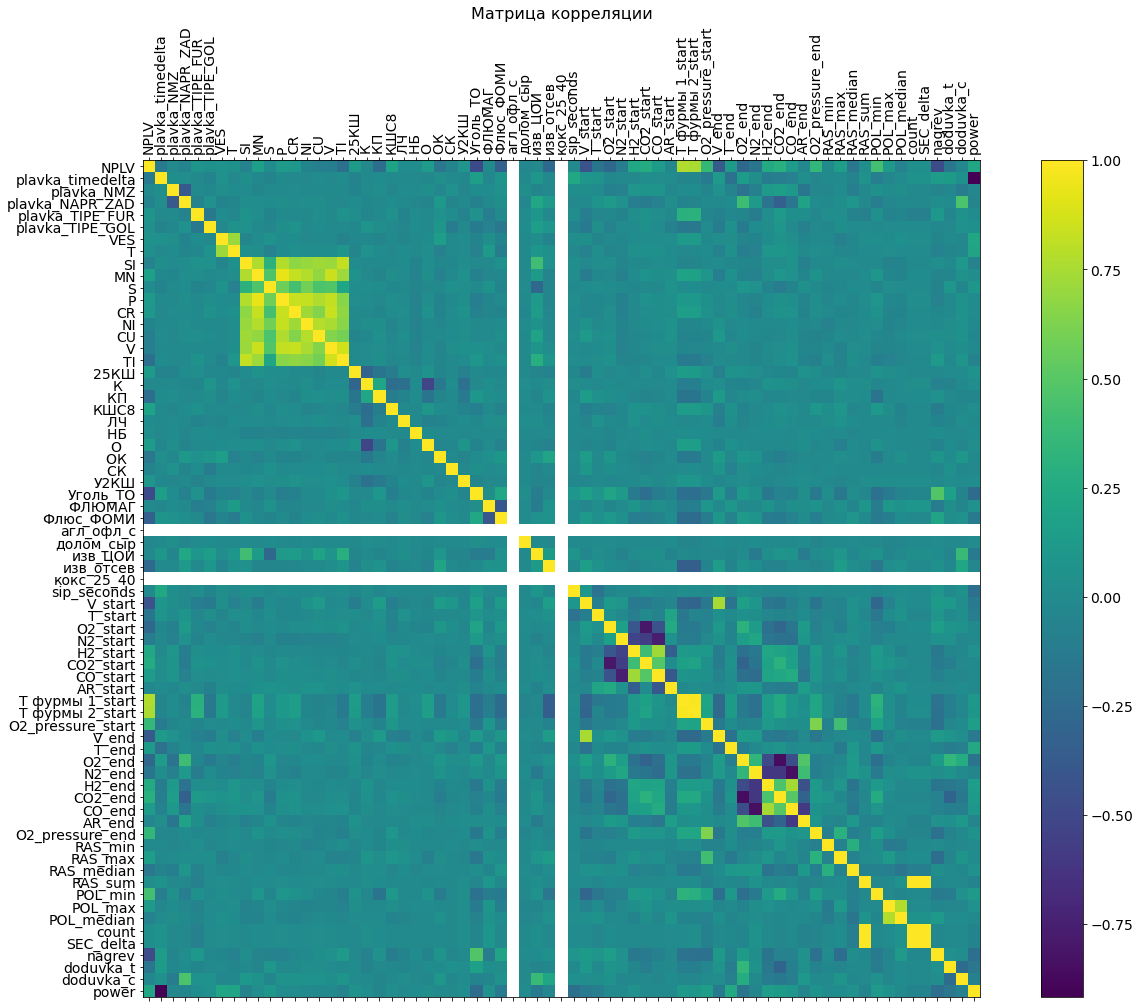

In [74]:
f = plt.figure(figsize=(22, 15))
plt.matshow(features_train.corr(), fignum=f.number)
plt.xticks(range(features_train.shape[1]), features_train.columns, fontsize=14, rotation=90)
plt.yticks(range(features_train.shape[1]), features_train.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Матрица корреляции', fontsize=16);

### Готовим модель с затюненными признаками

In [75]:
model = CatBoostRegressor(random_state=42, learning_rate=0.0015, 
                          verbose=250, eval_metric='RMSE', 
                          loss_function='RMSE', iterations=2500,
                          depth=10, l2_leaf_reg=7)

In [76]:
model.fit(features_train, target_train_['TST'])

0:	learn: 30.6573379	total: 343ms	remaining: 14m 17s
250:	learn: 27.4895499	total: 52.1s	remaining: 7m 47s
500:	learn: 25.2754990	total: 1m 39s	remaining: 6m 37s
750:	learn: 23.6448985	total: 2m 25s	remaining: 5m 39s
1000:	learn: 22.3713519	total: 3m 16s	remaining: 4m 54s
1250:	learn: 21.3717226	total: 4m 5s	remaining: 4m 5s
1500:	learn: 20.5357065	total: 5m	remaining: 3m 19s
1750:	learn: 19.8267619	total: 5m 56s	remaining: 2m 32s
2000:	learn: 19.2032362	total: 6m 46s	remaining: 1m 41s
2250:	learn: 18.6536555	total: 7m 23s	remaining: 49.1s
2499:	learn: 18.1689585	total: 7m 59s	remaining: 0us


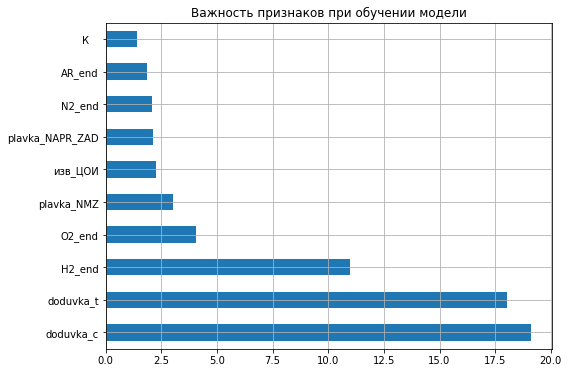

In [77]:
pd.Series(model.feature_importances_, index=features_train.columns).nlargest(10)\
                                                                       .plot(kind='barh', grid=True, figsize=(8,6), 
                                                                             title='Важность признаков при обучении модели');

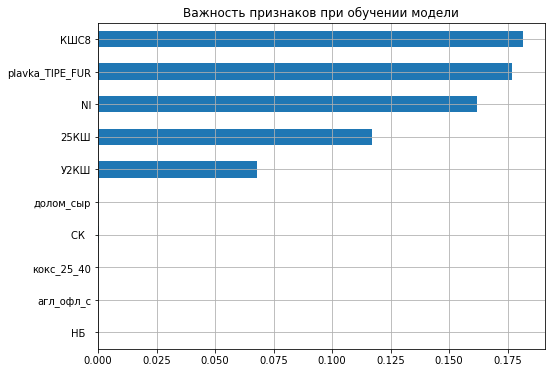

In [78]:
pd.Series(model.feature_importances_, index=features_train.columns).nsmallest(10)\
                                                                       .plot(kind='barh', grid=True, figsize=(8,6), 
                                                                             title='Важность признаков при обучении модели');

Предсказываем один признак - TST

In [79]:
pred_TST = model.predict(features_test)
pred_TST

array([1661.7785689 , 1651.14073956, 1651.76601161, 1649.74230235,
       1653.29463521, 1652.56450305, 1649.38121396, 1648.46626788,
       1647.28355246, 1652.81579848, 1663.21116591, 1648.77756585,
       1654.4625359 , 1651.21721084, 1652.7023438 , 1653.82272749,
       1653.12691957, 1649.38804773, 1650.33966354, 1652.36364252,
       1664.82349183, 1647.26324457, 1646.57943852, 1651.25954686,
       1646.71232408, 1652.20130519, 1665.80762722, 1666.26070824,
       1664.44184717, 1653.57782949, 1665.18174574, 1650.9872539 ,
       1645.65741102, 1644.01089243, 1644.45275289, 1650.31803034,
       1661.93461205, 1652.20770118, 1662.9693043 , 1650.00940215,
       1652.75477179, 1646.3619757 , 1651.1195436 , 1645.33158733,
       1645.60061592, 1664.01568166, 1650.99543607, 1642.29683159,
       1646.95738229, 1648.43686758, 1645.03499524, 1652.96850685,
       1662.07193988, 1650.37836978, 1651.28133966, 1662.45264816,
       1662.00772192, 1662.68492786, 1662.61228145, 1660.03733

Предсказываем другой признак - C

In [80]:
model.fit(features_train, target_train_['C'])
pred_C = model.predict(features_test)
pred_C

0:	learn: 0.1004376	total: 146ms	remaining: 6m 3s
250:	learn: 0.0883888	total: 42.6s	remaining: 6m 21s
500:	learn: 0.0789647	total: 1m 28s	remaining: 5m 54s
750:	learn: 0.0715962	total: 2m 14s	remaining: 5m 13s
1000:	learn: 0.0656349	total: 3m 2s	remaining: 4m 32s
1250:	learn: 0.0608766	total: 3m 53s	remaining: 3m 53s
1500:	learn: 0.0568342	total: 4m 43s	remaining: 3m 8s
1750:	learn: 0.0533966	total: 5m 33s	remaining: 2m 22s
2000:	learn: 0.0504406	total: 6m 26s	remaining: 1m 36s
2250:	learn: 0.0478498	total: 7m 19s	remaining: 48.6s
2499:	learn: 0.0454874	total: 8m 19s	remaining: 0us


array([0.05307385, 0.06089534, 0.08277738, 0.06123142, 0.08163282,
       0.09089679, 0.06756158, 0.06048207, 0.05617625, 0.07146247,
       0.07401936, 0.06424922, 0.05929272, 0.05689796, 0.05690685,
       0.08361237, 0.06354124, 0.07683821, 0.05461177, 0.05528953,
       0.05159603, 0.05626887, 0.06670302, 0.05371447, 0.06208833,
       0.05700898, 0.05313843, 0.05519851, 0.05293917, 0.05544744,
       0.05495746, 0.08404294, 0.05616003, 0.05334866, 0.05301451,
       0.07233907, 0.05201387, 0.05454573, 0.0795369 , 0.05214727,
       0.05618474, 0.05139608, 0.06630749, 0.05811414, 0.06076051,
       0.05182235, 0.05640219, 0.05350196, 0.05690359, 0.05759366,
       0.05412664, 0.05131855, 0.06681056, 0.05748962, 0.05534065,
       0.05532388, 0.05559936, 0.05330772, 0.05471146, 0.06581032,
       0.07952904, 0.05851527, 0.07611614, 0.05707788, 0.08489053,
       0.07522257, 0.05975505, 0.05867148, 0.05436863, 0.08313799,
       0.05563983, 0.06277189, 0.05429522, 0.05953748, 0.19140

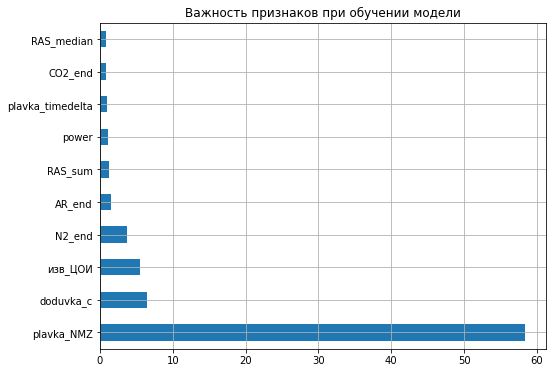

In [81]:
pd.Series(model.feature_importances_, index=features_train.columns).nlargest(10)\
                                                                       .plot(kind='barh', grid=True, figsize=(8,6), 
                                                                             title='Важность признаков при обучении модели');

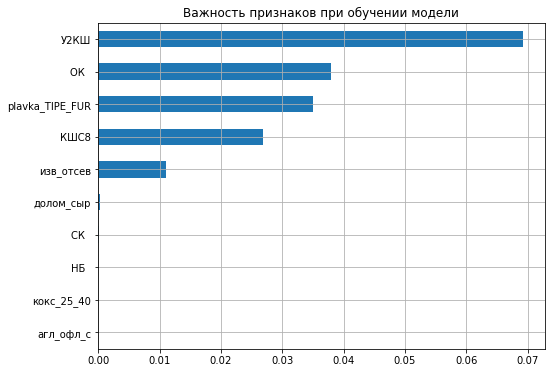

In [82]:
pd.Series(model.feature_importances_, index=features_train.columns).nsmallest(10)\
                                                                       .plot(kind='barh', grid=True, figsize=(8,6), 
                                                                             title='Важность признаков при обучении модели');

### Сабмитим

In [83]:
sub = pd.DataFrame(data={'NPLV': features_test['NPLV'], 'TST': pred_TST,  'C': pred_C})
sub

,NPLV,TST,C
0,512324,1661.778569,0.053074
1,512327,1651.140740,0.060895
2,512328,1651.766012,0.082777
3,512331,1649.742302,0.061231
4,512333,1653.294635,0.081633
...,...,...,...
775,513369,1660.668875,0.056337
776,513370,1661.124468,0.062335
777,513371,1664.813097,0.056493
778,513372,1663.093068,0.057366


In [84]:
pd.read_csv('sample_submission.csv')

,NPLV,TST,C
0,512324,1640,0.0
1,512327,1640,0.0
2,512328,1640,0.0
3,512331,1640,0.0
4,512333,1640,0.0
...,...,...,...
775,513369,1640,0.0
776,513370,1640,0.0
777,513371,1640,0.0
778,513372,1640,0.0


In [85]:
sub.to_csv('test05.csv', index=False)